In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pydot
from IPython.display import Image

from matplotlib.pyplot import subplots

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

from six import StringIO
import sklearn.model_selection as skm

%matplotlib inline

In [2]:
df = pd.read_csv('Hitters.csv').dropna()

In [3]:
df.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N
5,-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,...,501,336,194,A,W,282,421,25,750.0,A


In [4]:
feature_list = ['Years', 'Hits', 'Runs', 'Walks','RBI']
X = df[feature_list].values
y = np.log(df['Salary']).values

(X_train, X_test, y_train, y_test) = skm.train_test_split(
        X, y, test_size=0.3, random_state=0)

In [5]:
regr = DecisionTreeRegressor(max_leaf_nodes=3)
regr.fit(X, y)

DecisionTreeRegressor(max_leaf_nodes=3)

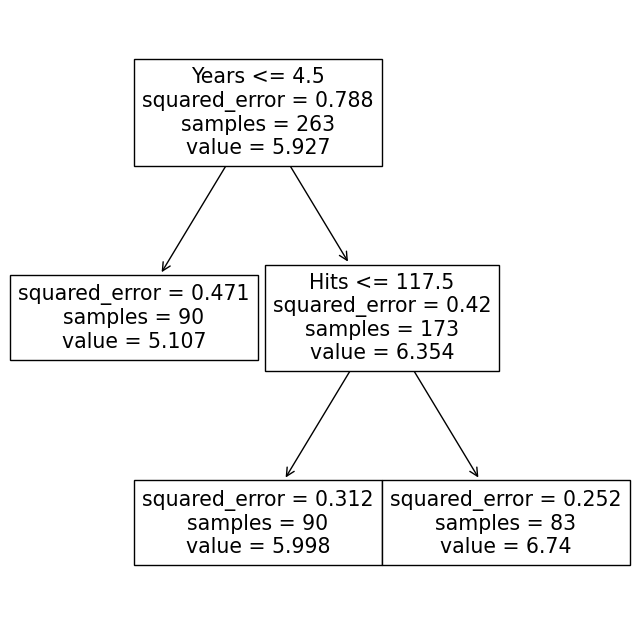

In [6]:
ax = subplots(figsize=(8,8))[1]
t = plot_tree(regr, feature_names=feature_list, ax=ax)

In [7]:
regr = DecisionTreeRegressor(random_state=0, max_leaf_nodes=8)
regr.fit(X_train, y_train)

DecisionTreeRegressor(max_leaf_nodes=8, random_state=0)

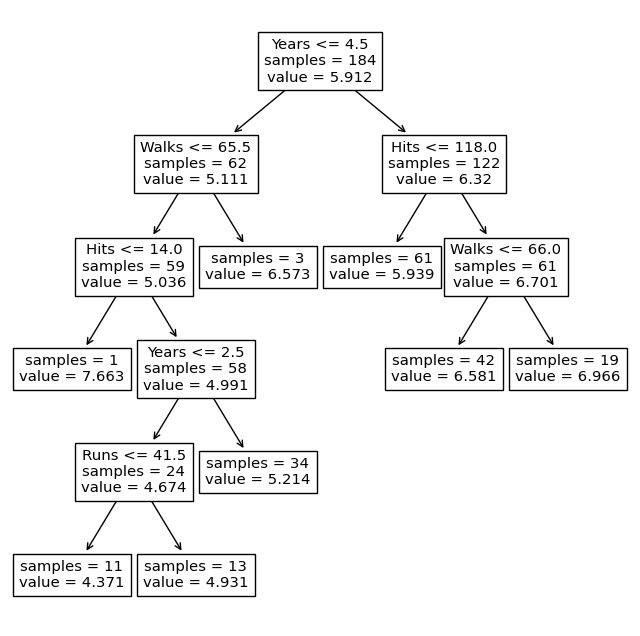

In [8]:
ax = subplots(figsize=(8,8))[1]
t = plot_tree(regr, feature_names=feature_list, impurity=False, ax=ax)

In [14]:
ccp_path = regr.cost_complexity_pruning_path(X_train, y_train) 

kfold = skm.KFold(5, shuffle=True, random_state=10)

grid = skm.GridSearchCV(
    regr, {'ccp_alpha': ccp_path.ccp_alphas},
    refit=True, cv=kfold, scoring='neg_mean_squared_error')

G = grid.fit(X_train, y_train)
ccp_alphas = ccp_path.ccp_alphas

In [15]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

0.3945784428868248

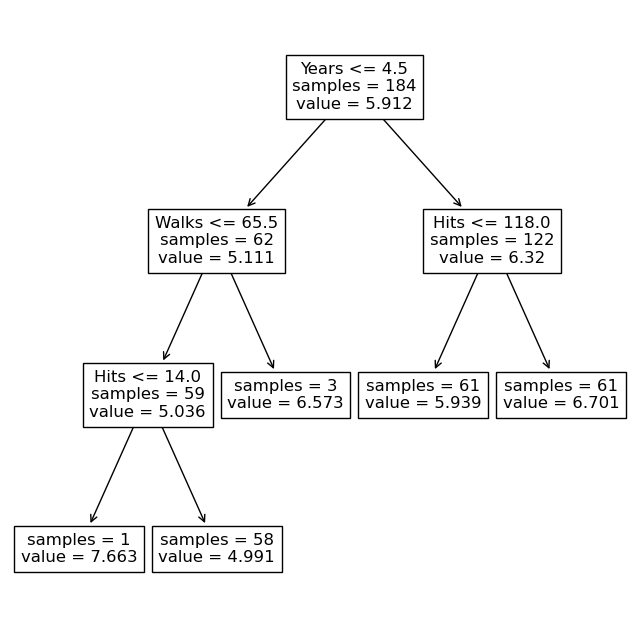

In [16]:
ax = subplots(figsize=(8,8))[1]
t = plot_tree(G.best_estimator_, feature_names=feature_list, impurity=False, ax=ax)

(0.0, 1.0, 0.0, 1.0)

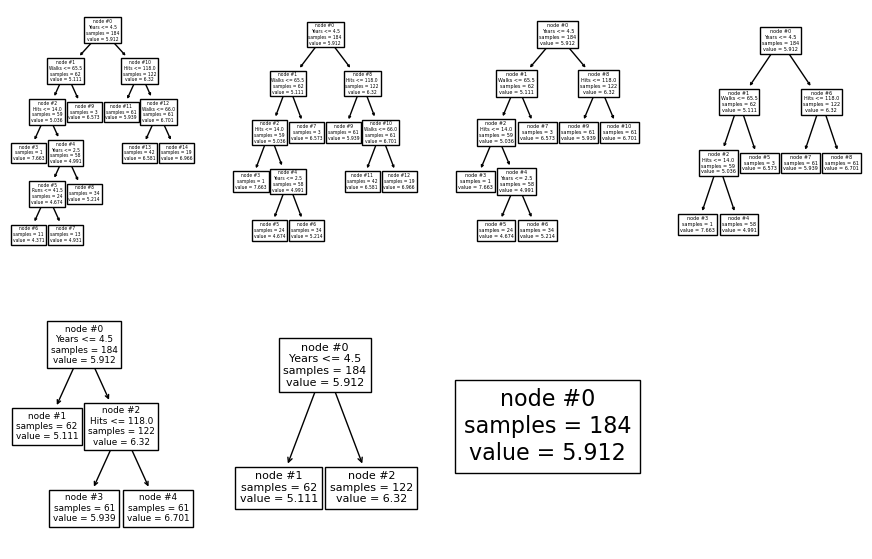

In [17]:
regrs = []
ax = subplots(figsize=(11,7), nrows=2, ncols=4)[1]
for l in range(ccp_alphas.size):
    ccp_alpha = ccp_alphas[l]
    regr_alpha = DecisionTreeRegressor(
            random_state=0, max_leaf_nodes=8, ccp_alpha=ccp_alpha+1e-8)
    regr_alpha.fit(X_train, y_train)
    regrs.append(regr_alpha)

    t = plot_tree(
        regr_alpha, feature_names=feature_list, 
        ax=ax.flat[l], impurity=False, node_ids=True)

ax.flat[-1].axis('off')

Text(0.5, 1.0, 'Total squared error vs effective alpha for training set')

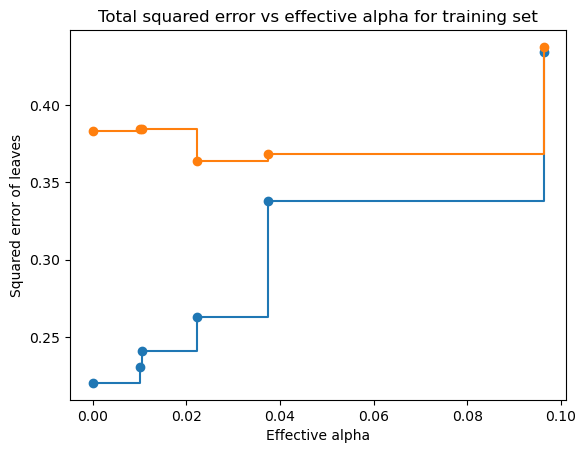

In [18]:
path = regr.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(
    ccp_alphas[:-1], impurities[:-1], 
    marker="o", drawstyle="steps-post", label='Training')
ax.plot(
    ccp_alphas[:-1], -G.cv_results_['mean_test_score'][:-1], 
    marker="o", drawstyle="steps-post", label='Average CV')
ax.set_xlabel("Effective alpha")
ax.set_ylabel("Squared error of leaves")
ax.set_title("Total squared error vs effective alpha for training set")

In [19]:
G.cv_results_

{'mean_fit_time': array([0.00124669, 0.00101886, 0.00081077, 0.00068164, 0.0006712 ,
        0.00067558, 0.00066109]),
 'std_fit_time': array([1.76771387e-04, 2.14407091e-04, 1.80614724e-04, 1.11858721e-05,
        1.08205268e-05, 2.02690009e-05, 9.58359653e-06]),
 'mean_score_time': array([0.0005898 , 0.00041313, 0.00031362, 0.00026369, 0.00025721,
        0.00025907, 0.00024977]),
 'std_score_time': array([9.44962526e-05, 1.06708805e-04, 5.65450463e-05, 1.46195504e-06,
        3.30155933e-06, 6.27108849e-06, 2.98775677e-06]),
 'param_ccp_alpha': masked_array(data=[0.0, 0.010150694222924863, 0.010529355797841589,
                    0.022284650353541706, 0.03738432139708027,
                    0.09630215902399242, 0.3267260444264579],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'ccp_alpha': 0.0},
  {'ccp_alpha': 0.010150694222924863},
  {'ccp_alpha': 0.010529355797841589},
  {'ccp_alpha': 0.022

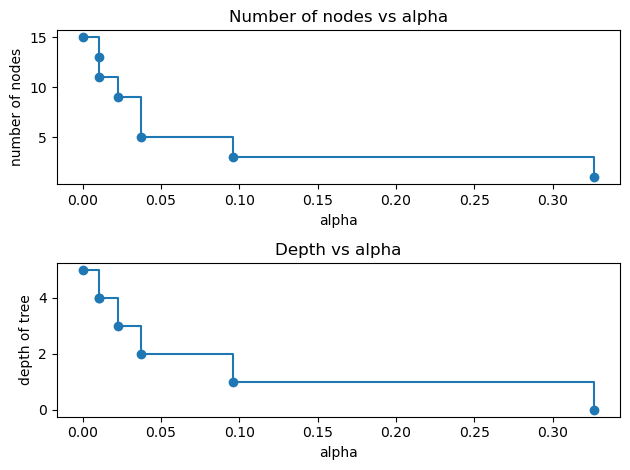

In [20]:
node_counts = [regr_alpha.tree_.node_count for regr_alpha in regrs]
depth = [regr_alpha.tree_.max_depth for regr_alpha in regrs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [21]:
# Boosting

In [77]:
lambda_ = 0.01
B = 10000
d = 2

In [78]:
X = np.vstack((X_train, X_test))
y = np.concatenate((y_train, y_test))

train_ind = list(range(X_train.shape[0]))
test_ind = list(range(X_test.shape[0]))
test_ind = [x + X_train.shape[0] for x in test_ind]

In [79]:
regr = DecisionTreeRegressor(max_depth=d)
regr.fit(X[train_ind], y[train_ind])

f_hat = np.zeros((y.size, B))
f_hat[:, 0] = regr.predict(X)

r = np.zeros((y.size, B))
r[:, 0] = y - regr.predict(X)

y_hat = np.zeros((y.size, B))
y_hat[:, 0] = f_hat[:, 0]

mse = np.zeros((B))
mse[0] = np.mean((y - y_hat[:, 0])**2)

mse_train = np.zeros((B))
mse_train[0] = np.mean((y[train_ind] - y_hat[train_ind, 0])**2)

mse_test = np.zeros((B))
mse_test[0] = np.mean((y[test_ind] - y_hat[test_ind, 0])**2)

In [80]:
for b in range(1, B):
    r[:, b] = y - y_hat[:, b-1]
    regr.fit(X[train_ind], r[train_ind, b])
    f_hat[:, b] = regr.predict(X)
    y_hat[:, b] = y_hat[:, b-1] + lambda_ * f_hat[:, b]
    mse[b] = np.mean((y - y_hat[:, b])**2)
    mse_train[b] = np.mean((y[train_ind] - y_hat[train_ind, b])**2)
    mse_test[b] = np.mean((y[test_ind] - y_hat[test_ind, b])**2)

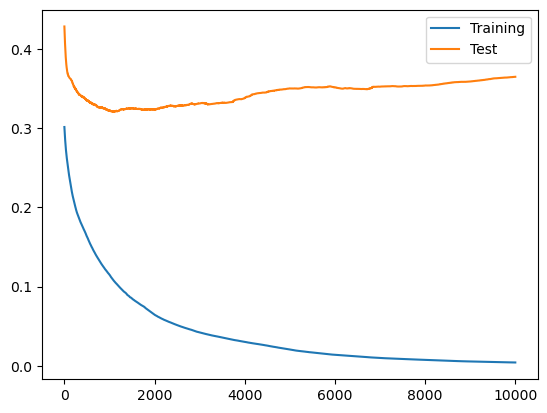

In [82]:
plt.plot(range(B), mse_train, label='Training')
plt.plot(range(B), mse_test, label='Test')
plt.legend()